# BOVA11/SPY Option Pricing

In [1]:
## Needed libs

import numpy as np
from scipy import inf, pi, linspace, zeros, imag, array
from numpy import log, exp, real
from scipy.stats import norm
from scipy.integrate import quad
import pandas as pd
import os
import time
from matplotlib import pyplot
import math

## BOVA options

In [3]:
iv_surface = pd.read_csv("../data/opcoes_bova11.csv", sep=';')

iv_surface['strike'] = iv_surface['strike'].apply(lambda x: float(x.replace(",", ".")))
iv_surface['spot'] = iv_surface['spot'].apply(lambda x: float(x.replace(",", ".")))
iv_surface['iv'] = iv_surface['iv'].apply(lambda x: float(str(x).replace(",", ".")))
iv_surface['preco'] = iv_surface['preco'].apply(lambda x: float(str(x).replace(",", ".")))
iv_surface["moneyness"] = iv_surface["spot"] / iv_surface["strike"]
iv_surface["ano_vencimento"] = iv_surface["dias_vencimento"] / 360
iv_surface = iv_surface.dropna(subset = ['iv'])
iv_surface = iv_surface.loc[iv_surface['type'] == 'CALL']

df_options = iv_surface
df_options['vencimento'] = pd.to_datetime(df_options['vencimento'], format = '%d/%m/%Y')

df_options = df_options[(df_options['preco'] > 1)]

df_options = df_options.reset_index(drop=True)


print(iv_surface.isnull().sum())
print(iv_surface.dtypes)


ticker             0
vencimento         0
dias_vencimento    0
type               0
mod                0
strike             0
preco              0
data               0
iv                 0
spot               0
moneyness          0
ano_vencimento     0
dtype: int64
ticker                     object
vencimento         datetime64[ns]
dias_vencimento             int64
type                       object
mod                        object
strike                    float64
preco                     float64
data                       object
iv                        float64
spot                      float64
moneyness                 float64
ano_vencimento            float64
dtype: object


## SPY options

In [3]:
iv_surface = pd.read_csv("../data/spy_yfinance_call.csv")
iv_surface = iv_surface.dropna(subset = ['preco'])

## Iniciando processo do modelo de Heston

In [8]:
## Gerando lista de dados de mercado

list_market_data = [(row['preco'], row['spot'], row['strike'], row['ano_vencimento']) for index, row in iv_surface.iterrows()]

In [9]:
## Needed functions

def heston_phi(k, tau, *parms):

    ## PARAMETERS
    ## v0: initial volatility
    ## v_long: long-term average volatility
    ## mean_reversion: mean-reversion speed
    ## vol_vol: volatility of vol process
    ## rho: correlation between stock and vol
    ## r: risk-free interest rate
    ## tau: time to maturity
    ## S0: initial share price
    ## K: strike price

	v0, v_long, mean_reversion, vol_vol, rho = parms
	
	b = mean_reversion + 1j*rho*vol_vol*k
	d = np.sqrt( b**2 + (vol_vol**2)*k*(k-1j) )
	g = (b - d)/(b + d)
	T_m = (b - d)/(vol_vol**2)
	T = T_m * ( 1 - exp(-d*tau) )/( 1 - g*exp(-d*tau) )
	W = mean_reversion * v_long * ( tau*T_m - 2*log( ( 1 - g*exp(-d*tau) )/( 1 - g ) )/(vol_vol**2) )
	
	return exp(W + v0*T)

def heston_phi_transform(tau, x, *parms):
	integrand = lambda k: 2 * real( exp(-1j*k*x) * heston_phi(k + 0.5*1j, tau, *parms) )/(k**2 + 1.0/4.0)
	return quad(integrand, 0, 50)[0]

def heston_ucall(F, K, tau, *parms):
	'''Heston call'''
	x = log(F/K)
	return F - (np.sqrt(K*F)/(2*pi)) * heston_phi_transform(tau, x, *parms)

def heston_call(S, K, tau, r, q, *parms):
	'''Heston call'''
	F = S*exp((r-q)*tau)
	x = log(F/K)
	integral = heston_phi_transform(tau, x, *parms)
	return S * exp(-q*tau) - K * exp(-r*tau) * integral

def heston_evaluate(chromo):
    """docstring for heston_evaluate"""
    v0 = chromo[0]
    v_long = chromo[1]
    mean_reversion = chromo[2]
    vol_vol = chromo[3]
    rho = chromo[4]

    lista_erro = [] 
    lista_erro = [abs(i[0] - heston_ucall(i[1], i[2], i[3], v0, v_long, mean_reversion, vol_vol, rho))/i[0] for i in list_market_data]
  
    # for index, row in iv_surface.iterrows():
    #     lista_erro.append(abs(row["preco"] - heston_ucall(row["spot"], row["strike"], row["ano_vencimento"], v0, v_long, mean_reversion, vol_vol, rho))/row['preco'])

    diffs = sum(lista_erro)/len(lista_erro)

    return diffs

# def heston_evaluate(chromo):
#     """docstring for heston_evaluate"""
#     v0 = chromo[0]
#     v_long = chromo[1]
#     mean_reversion = chromo[2]
#     vol_vol = chromo[3]
#     rho = chromo[4]

#     lista_erro = []
#     #print(row["price"] - heston_ucall(row["spot"], row["strike"], row["t_ano"], *[0.02688, 0.08847, 0.3587, 0.7535, -0.79])) #v, vbar, lambd, eta, rho
  
#     for index, row in iv_surface.iterrows():
#         lista_erro.append(abs(row["preco"] - heston_ucall(row["spot"], row["strike"], row["ano_vencimento"], v0, v_long, mean_reversion, vol_vol, rho))/row['preco'])

#     diffs = sum(lista_erro)/len(lista_erro)

#     return diffs

## Executing optimization and pricing

In [10]:
####DIFFERENTIAL EVOLUTION####
from scipy.optimize import differential_evolution

start = time.time()

result = differential_evolution(heston_evaluate,
    workers = -1,
    disp = True,
    bounds = [(0,1), (0, 1), (0, 5), (0, 5), (-1, 1)],
    maxiter = 30)

optimized_parameters = result.x

end = time.time()

print((end - start)/60)

price_pred_list = []

for index, row in iv_surface.iterrows():
    price_pred_list.append(heston_ucall(row["spot"], row["strike"], row["ano_vencimento"], *optimized_parameters))

iv_surface["pred_preco"] = price_pred_list
iv_surface["erro"] = iv_surface["preco"] - iv_surface["pred_preco"]


differential_evolution step 1: f(x)= 0.418129
differential_evolution step 2: f(x)= 0.394048
differential_evolution step 3: f(x)= 0.348359
differential_evolution step 4: f(x)= 0.348359
differential_evolution step 5: f(x)= 0.348359
differential_evolution step 6: f(x)= 0.348359
differential_evolution step 7: f(x)= 0.348359
differential_evolution step 8: f(x)= 0.348359
differential_evolution step 9: f(x)= 0.348359
differential_evolution step 10: f(x)= 0.342624
differential_evolution step 11: f(x)= 0.342311
differential_evolution step 12: f(x)= 0.342311
differential_evolution step 13: f(x)= 0.342311
differential_evolution step 14: f(x)= 0.340897
differential_evolution step 15: f(x)= 0.340808
differential_evolution step 16: f(x)= 0.339572
differential_evolution step 17: f(x)= 0.33887
differential_evolution step 18: f(x)= 0.33887
differential_evolution step 19: f(x)= 0.33887
differential_evolution step 20: f(x)= 0.33887
differential_evolution step 21: f(x)= 0.338322
differential_evolution ste

In [11]:
print(optimized_parameters)

# v0 = chromo[0]
# v_long = chromo[1]
# mean_reversion = chromo[2]
# vol_vol = chromo[3]
# rho = chromo[4]

[ 0.15435942  0.13545061  4.98328399  1.47668642 -0.53696686]


## With Nelder-Mead

In [4]:
####NELDER-MEAD####
from scipy.optimize import minimize

start = time.time()

results2 = minimize(fun = heston_evaluate,
 x0 = [0.01, 0.01,  2, 0.1, -0.3], ##já otimizados: 0.01541238,  0.03842705,  0.46946754,  0.08467337, -0.60026253
 method = "Nelder-Mead",
 options={'disp': True,
          'maxiter': 100})

end = time.time()

print((end - start)/60)

optimized_parameters2 = results2.x

price_pred_list = []

for index, row in iv_surface.iterrows():
    price_pred_list.append(heston_ucall(row["spot"], row["strike"], row["ano_vencimento"], *optimized_parameters2))

iv_surface["pred_price"] = price_pred_list
iv_surface["erro"] = iv_surface["preco"] - iv_surface["pred_price"]



ipykernel_launcher:33: DeprecationWarning: scipy.log is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.log instead
ipykernel_launcher:28: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
ipykernel_launcher:22: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
ipykernel_launcher:23: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
ipykernel_launcher:23: DeprecationWarning: scipy.log is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.log instead
ipykernel_launcher:25: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
ipykernel_launcher:28: DeprecationWarning: scipy.real is deprecated and will be removed in SciPy 2.0.0, use numpy.real instead
11.824149823188781


In [6]:
print(optimized_parameters2)

    ## PARAMETERS
    ## v0: initial volatility
    ## v_long: long-term average volatility
    ## mean_reversion: mean-reversion speed
    ## vol_vol: volatility of vol process
    ## rho: correlation between stock and vol

##### [ 0.13399999  0.11106412  3.8104492   0.55789332 -0.55151821]

[ 0.13551386 -0.01232252  2.78471963 -0.79423821  0.28776318]


## Results

3.5292890053949493

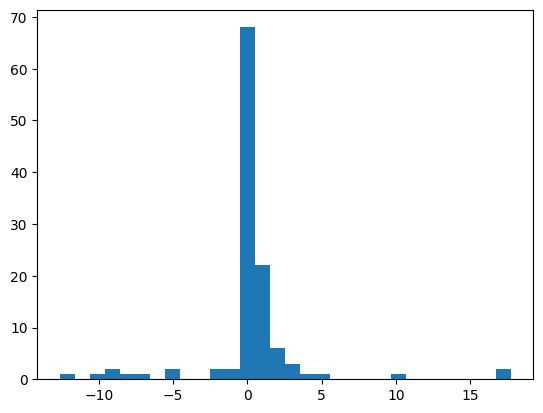

In [110]:
pyplot.hist(iv_surface["erro"], bins = 30)

erro_quadrado = iv_surface["erro"]**2

erro_quadrado = math.sqrt(erro_quadrado.mean())
erro_quadrado


In [112]:
import statsmodels.api as sm

x = iv_surface['pred_preco']
y = iv_surface['preco']

model = sm.OLS(y, x).fit()
print(model.summary())


OLS Regression Results                                
Dep. Variable:                  preco   R-squared (uncentered):                   0.886
Model:                            OLS   Adj. R-squared (uncentered):              0.885
Method:                 Least Squares   F-statistic:                              894.1
Date:                Tue, 15 Sep 2020   Prob (F-statistic):                    4.58e-56
Time:                        16:00:08   Log-Likelihood:                         -310.48
No. Observations:                 116   AIC:                                      623.0
Df Residuals:                     115   BIC:                                      625.7
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

In [114]:
## Needed libs for visualization

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D  
from matplotlib import cm


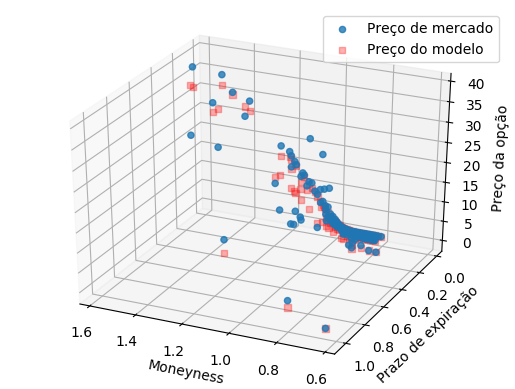

In [117]:
###PLOT DOS PONTOS
fig = plt.figure()
plt.style.use('default')
fig.set_facecolor("w")
ax = plt.axes(projection='3d')
ax.scatter3D(iv_surface["moneyness"], iv_surface["ano_vencimento"], iv_surface["preco"], label = "Preço de mercado", alpha = 0.8)
ax.scatter3D(iv_surface["moneyness"], iv_surface["ano_vencimento"], iv_surface["pred_preco"], c = "red", label = 'Preço do modelo', alpha = 0.3, marker = "s")
ax.view_init(elev=30, azim = 115) #azim=45
ax.set_xlabel('Moneyness')
ax.set_ylabel('Prazo de expiração')
ax.set_zlabel('Preço da opção')
ax.legend()


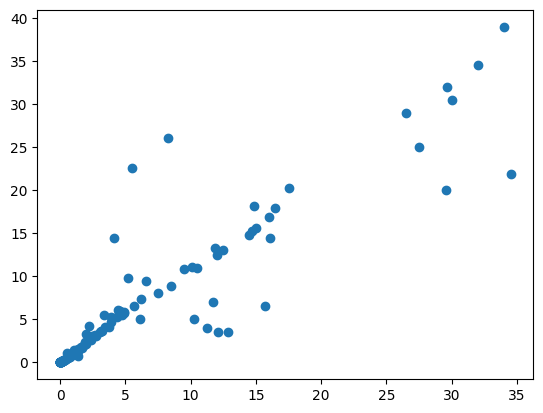

In [118]:
plt.scatter(x, y)

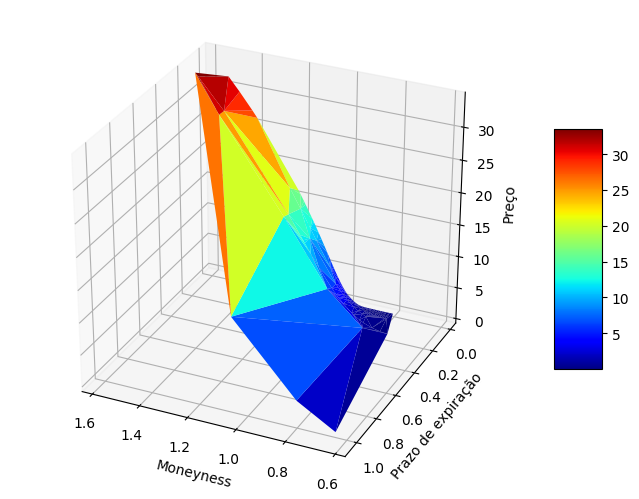

In [120]:
###PLOT DA SUPERFÍCIE DOS PREÇOS PREDITOS
fig = plt.figure()
plt.style.use('default')
fig.set_facecolor("w")
ax = Axes3D(fig)
surf = ax.plot_trisurf(iv_surface["moneyness"], iv_surface["ano_vencimento"], iv_surface["pred_preco"], cmap=cm.jet, linewidth=0.1)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('Moneyness')
ax.set_ylabel('Prazo de expiração')
ax.set_zlabel('Preço')
ax.view_init(elev=30., azim=115)
plt.show()

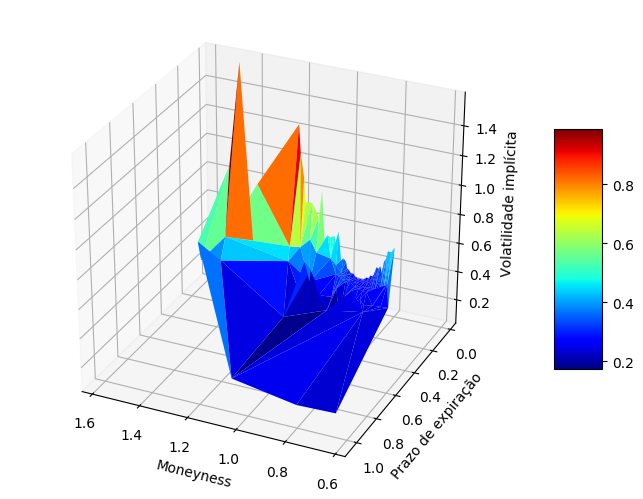

In [121]:
###PLOT DA SUPERFÍCIE DA VOLATILIDADE
fig = plt.figure()
plt.style.use('default')
fig.set_facecolor("w")
ax = Axes3D(fig)
surf = ax.plot_trisurf(iv_surface["moneyness"], iv_surface["ano_vencimento"], iv_surface["iv"], cmap=cm.jet, linewidth=0.1)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('Moneyness')
ax.set_ylabel('Prazo de expiração')
ax.set_zlabel('Volatilidade implícita')
ax.view_init(elev=30., azim=115)
plt.show()